In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random

In [2]:
words = open("data/names.txt", "r").read().splitlines()

In [3]:
#build vocabulary of character and mapping
chars = sorted(list(set("".join(words))))
stoi = {char: i+1 for i, char in enumerate(chars)}
stoi["."] = 0
itos = {i: char for char, i in stoi.items()}
vocab_size = len(itos)

In [4]:
#build the dataset
block_size = 8
def build_dataset(words):
    X = []
    Y = []
    for word in words:
        context = [0] * block_size
        
        for char in word + ".":
            idx = stoi[char]
            Y.append(idx)
            X.append(context)
            context = context[1:] + [idx]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y
import random
random.shuffle(words)
s1 = int(0.8 * len(words))
s2 = int(0.9 * len(words))

X_train, Y_train = build_dataset(words[:s1])
X_val, Y_val = build_dataset(words[s1:s2])
X_test, Y_test = build_dataset(words[s2:])

torch.Size([182461, 8]) torch.Size([182461])
torch.Size([22820, 8]) torch.Size([22820])
torch.Size([22865, 8]) torch.Size([22865])


In [5]:
class Linear:
    def __init__(self, fan_in, fan_out, bias = True):
        self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 #kaiming init
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out +=self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    
class BatchNorm1d:
    def __init__(self, dim, eps = 1e-5, momentum = 0.1):
        self.eps = eps #verhindert teilung durch 0
        self.momentum = momentum
        self.training = True
        #paramters - trained with backpro
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        #buffers - trianing with momentum
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
    
    def __call__(self, x):
        if self.training:
            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3:
                dim = (0,1)
            xmean = x.mean(dim, keepdim = True)
            xvar = x.var(dim, keepdim = True)
        else: 
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x-xmean) / torch.sqrt(xvar + self.eps)# verteilung pro neuron zentriern und skalieren
        self.out = self.gamma * xhat + self.beta
        #update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1-self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1-self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
    

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []          
    

class Embedding:
    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim)) #lookuptable erstellen

    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out
    
    def parameters(self):
        return [self.weight]

class FlattenConsecutive:

    def __init__(self, n):
        self.n = n

    def __call__(self, x):
        B, T, C = x.shape
        x = x.view(B, T//self.n, C*self.n)
        if x.shape[1] == 1: # wenns wie vorher ist (alle embeddings über block_size flattenen)
            x = x.squeeze(1) #remove dimension -> eg. 32x10
        self.out = x
        return self.out
    
    def parameters(self):
        return []
    
class Sequential: #container: organizing layers -> maintains lift of layers and passes input through

    def __init__(self, layers):
        self.layers = layers

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]



In [6]:
n_embd = 24
n_hidden = 128

# C = torch.randn((vocab_size, n_embd))
model = Sequential(
    [Embedding(vocab_size, n_embd),
    FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias = False), BatchNorm1d(n_hidden),Tanh(),
    FlattenConsecutive(2), Linear(n_hidden* 2, n_hidden, bias = False), BatchNorm1d(n_hidden),Tanh(),
    FlattenConsecutive(2), Linear(n_hidden* 2, n_hidden, bias = False), BatchNorm1d(n_hidden),Tanh(),
    Linear(n_hidden, vocab_size)])

with torch.no_grad():
    model.layers[-1].weight *= 0.1 #make last layer less confidetn to avoid hockey loss

parameters = model.parameters()
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

76579


In [7]:
#optimization
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    ix = torch.randint(0, X_train.shape[0], (batch_size, ))
    Xb, Yb = X_train[ix], Y_train[ix]

    #forward pass

    # emb = C[Xb]
    # x = emb.view(emb.shape[0], -1)
    logits = model(Xb)
   
    loss = F.cross_entropy(logits, Yb)

    # backward pass
    for p in parameters:
        p.grad = None #gradienten vom schrit vohrer nicht aufaddieren
    loss.backward()

    #update
    lr = 0.1 if i < 50000 else 0.01
    for p in parameters:
        p.data = p.data - lr * p.grad

    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps: 7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())



      0/ 200000: 3.3058
  10000/ 200000: 2.0777
  20000/ 200000: 2.4900
  30000/ 200000: 2.2402
  40000/ 200000: 1.8335
  50000/ 200000: 1.7406
  60000/ 200000: 1.6185
  70000/ 200000: 1.5244
  80000/ 200000: 1.5018
  90000/ 200000: 1.8846
 100000/ 200000: 2.0231
 110000/ 200000: 1.8439
 120000/ 200000: 1.9558
 130000/ 200000: 2.1000
 140000/ 200000: 1.8951
 150000/ 200000: 1.9839
 160000/ 200000: 1.4653
 170000/ 200000: 1.4945
 180000/ 200000: 2.0926
 190000/ 200000: 1.9778


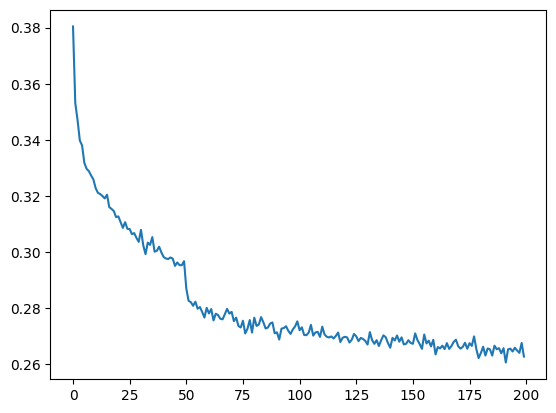

In [8]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1)) #summing over 1000 elements in loss to create nicer plot

In [9]:
#put layer into eval - batchnorm
for layer in model.layers:
    layer.training = False

In [10]:
#evaluate loss
@torch.no_grad()
def split_loss(split):
    x,y = {
        "train": (X_train, Y_train),
        "val": (X_val, Y_val),
        "test": (X_test, Y_test)
    }[split]
    
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())
split_loss("train")
split_loss("val")

train 1.8174279928207397
val 1.9861243963241577


In [11]:
# sample from the model
for _ in range(10):
    out = []
    context = [0] * block_size
    while True:
        #forward pass 
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim = 1)
        ix = torch.multinomial(probs, num_samples=1).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
        
    print("".join(itos[i] for i in out))

angelia.
arvin.
kenen.
safiem.
deylon.
zikhani.
ashvil.
aarielle.
ezra.
reigh.
